In [1]:
import numpy as np
from tqdm import tqdm
import math
from inspect import isfunction
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange
import torch
from torch import nn, einsum
import torch.nn.functional as F

/home/yoni/miniconda3/envs/f/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def abar(t, T): return (t/T*math.pi/2).cos()**2


In [3]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return (alp, ab, (1-alp).sqrt()) # alpha, alpha_bar, sigma
     


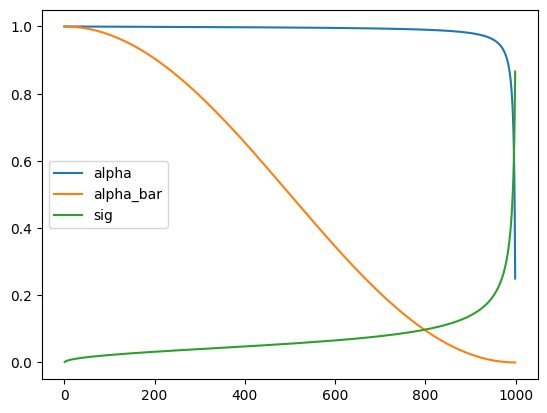

In [6]:
sched = cos_sched()
cos_alpha, cos_abar, cos_sig = sched
plt.plot(cos_alpha, label='alpha'), plt.plot(cos_abar, label='alpha_bar'), plt.plot(cos_sig, label='sig')
plt.legend()

In [3]:
num_timesteps = 256

def noisify(x0, alpha_bar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, num_timesteps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1).to(device)
    xt = alpha_bar_t.sqrt()*x0 + (1-alpha_bar_t).sqrt()*ε
    return (xt, t.to(device)), ε


In [ ]:
def ddim_step(x_t:np.ndarray, t:int, noise:float, abar_t:float, abar_t1:float, bbar_t:float, bbar_t1:float, eta:float):
  '''
  Predict x_t1 (x at timestep t-1).
  
  Args:
  x_t - x at timestep t.
  t - timestep.
  noise - noise.
  abar_t - alpha bar at timestep t.
  abar_t1 - alpha bar at timestep t-1.
  bbar_t - beta bar (i.e, "1 - alpha bar") at timestep t.
  bbar_t1 - beta bar (i.e, "1 - alpha bar") at timestep t-1.
  eta - the degree to which we're interpolating between ddim and ddpm. 0 is deterministic ddim. 1 is original ddpm.
  '''
  vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
  sig = vari.sqrt()*eta
  x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
  x_t1 = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
  if t>0: x_t1 += sig * torch.randn(x_t1.shape).to(x_t1)
  return x_t1

In [ ]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(tqdm(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

sz = (2048,1,32,32)
model = None
samples = sample(ddim_step, model, sz, 1000, 10)


In [2]:
def extract(a, t, x_shape):
  batch_size = t.shape[0]
  out = a.gather(-1, t.cpu())
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [ ]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


In [10]:
from diffusion_utils import *


In [11]:
# define alphas 
betas = ls
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)



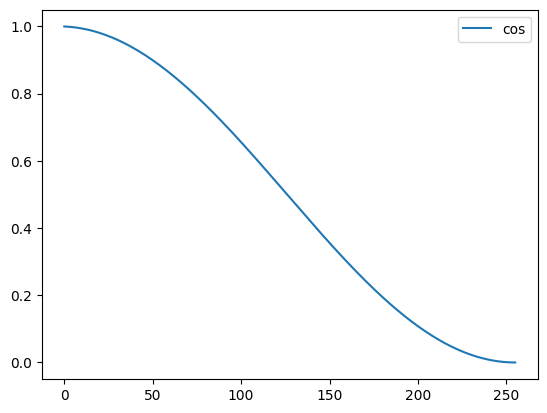

In [14]:
plt.plot(alphas_cumprod, label='cos')#, plt.plot(ls, label='lin')
plt.legend()

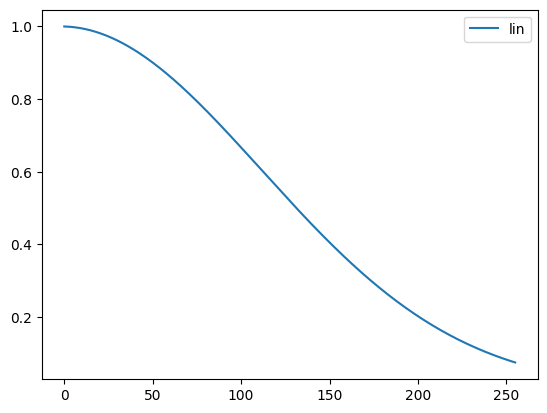

In [12]:
plt.plot(alphas_cumprod, label='lin')#, plt.plot(ls, label='lin')
plt.legend()